In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
obj2info = pd.read_csv("../data/processed/OM_obj_to_info.csv")
file2obj = pd.read_csv("../data/processed/OM_file_to_obj.csv")

In [3]:
file_counts = file2obj["obj_num"].value_counts()
# file2obj

In [4]:
file_counts

obj_num
durom.1969.406             249
durom.1973.47              191
DUROM.1954.Spalding29.W    112
durom.1960.2332            101
durom.2014.1                76
                          ... 
durom.2006.46.32             1
durom.2006.44.16             1
durom.2006.45.194            1
durom.2006.46.13             1
durom.1964.183               1
Name: count, Length: 12642, dtype: int64

In [5]:
distribution_df = pd.DataFrame()
distribution_df["Images per instance"] = file_counts.value_counts().sort_index().index
distribution_df["Number of instances"] = file_counts.value_counts().sort_index().values
distribution_df["Number of images"] = (
    distribution_df["Images per instance"] * distribution_df["Number of instances"]
)
num_instances_10plus = distribution_df[distribution_df["Images per instance"] >= 10][
    "Number of instances"
].sum()
num_images_10plus = distribution_df[distribution_df["Images per instance"] >= 10][
    "Number of images"
].sum()
distribution_df = distribution_df[
    (distribution_df["Images per instance"] < 10) & (distribution_df["Images per instance"] > 2)
]

distribution_df = pd.concat(
    [
        distribution_df,
        pd.DataFrame(
            {
                "Images per instance": ["10+"],
                "Number of instances": [num_instances_10plus],
                "Number of images": [num_images_10plus],
            }
        ),
    ],
    ignore_index=True,
)

# append total
distribution_df = pd.concat(
    [
        distribution_df,
        pd.DataFrame(
            {
                "Images per instance": ["Total"],
                "Number of instances": [distribution_df["Number of instances"].sum()],
                "Number of images": [distribution_df["Number of images"].sum()],
            }
        ),
    ],
    ignore_index=True,
)
# distribution_df = distribution_df[['Images per instance', 'Number of images', 'Number of instances']]
distribution_df

Images per instance  Number of instances  Number of images
0                   3                  696              2088
1                   4                  703              2812
2                   5                  360              1800
3                   6                  853              5118
4                   7                  471              3297
5                   8                  223              1784
6                   9                  110               990
7                 10+                  456              7836
8               Total                 3872             25725

This distribution broadly follows that from Winterbottom's paper, with a few minor differences. 

I am not expecting it to be exactly the same, as winterbottom did not use the database at all, instead just looked at the images

## Assessing for alternative text labels

In [61]:
full_df = pd.read_excel("../data/raw/Durham_University_Museums_data.xlsx")
full_df = full_df.filter(regex=r"^(?!Unnamed).*$")
full_df = full_df.dropna(subset=["description"])

In [69]:
null_percentage = (full_df.isnull().sum() / len(full_df)) * 100
desc_df = pd.DataFrame(
    {"Column": null_percentage.index, "Null Percentage": null_percentage.values}
)
desc_df["Null Percentage"] = desc_df["Null Percentage"].round(2)
desc_df = desc_df.sort_values(by="Null Percentage")
desc_df["unique_values"] = full_df.nunique().values
desc_df

Column  Null Percentage  unique_values
0            object_number             0.00          53460
4              description             0.00           1191
6                 material             4.43           6442
1              object_name             8.96          26163
22      alternative_number            18.30          46165
13        production.place            34.42           3234
12       production.period            40.90            414
3   reproduction.reference            50.23             76
11     production.date.end            50.90           6923
10   production.date.start            51.04            127
2               other_name            58.72            968
9          number_of_parts            62.08            949
8     physical_description            73.54            485
14        field_coll.place            77.88            812
16       field_coll.method            83.38            546
18         content.subject            87.25           1449
7                technique            87.58             22
21     association.subject            88.35            516
15        field_coll.notes            91.09            773
5               label.text            91.69             78
20      association.person            95.54            289
17     content.person.name            95.89            247
19      association.period            97.70          36718

In [97]:
def get_distribution(df, column, lower_bound=2):
    distribution = pd.DataFrame()
    col_counts = df[column].value_counts()
    distribution[f"{column}s per instance"] = col_counts.value_counts().sort_index().index
    distribution["Number of instances"] = col_counts.value_counts().sort_index().values
    distribution[f"Number of {column}s"] = (
        distribution[f"{column}s per instance"] * distribution["Number of instances"]
    )
    num_instances_10_50 = distribution[
        (distribution[f"{column}s per instance"] >= 10)
        & (distribution[f"{column}s per instance"] < 50)
    ]["Number of instances"].sum()
    num_images_10_50 = distribution[
        (distribution[f"{column}s per instance"] >= 10)
        & (distribution[f"{column}s per instance"] < 50)
    ][f"Number of {column}s"].sum()
    num_instances_50_100 = distribution[
        (distribution[f"{column}s per instance"] >= 50)
        & (distribution[f"{column}s per instance"] < 100)
    ]["Number of instances"].sum()
    num_images_50_100 = distribution[
        (distribution[f"{column}s per instance"] >= 50)
        & (distribution[f"{column}s per instance"] < 100)
    ][f"Number of {column}s"].sum()
    num_instances_100_1000 = distribution[
        (distribution[f"{column}s per instance"] >= 100)
        & (distribution[f"{column}s per instance"] < 1000)
    ]["Number of instances"].sum()
    num_images_100_1000 = distribution[
        (distribution[f"{column}s per instance"] >= 100)
        & (distribution[f"{column}s per instance"] < 1000)
    ][f"Number of {column}s"].sum()
    num_instances_1000plus = distribution[distribution[f"{column}s per instance"] >= 1000][
        "Number of instances"
    ].sum()
    num_images_1000plus = distribution[distribution[f"{column}s per instance"] >= 1000][
        f"Number of {column}s"
    ].sum()

    distribution = distribution[
        (distribution[f"{column}s per instance"] < 10)
        & (distribution[f"{column}s per instance"] > lower_bound)
    ]

    distribution = pd.concat(
        [
            distribution,
            pd.DataFrame(
                {
                    f"{column}s per instance": ["10-50"],
                    "Number of instances": [num_instances_10_50],
                    f"Number of {column}s": [num_images_10_50],
                }
            ),
            pd.DataFrame(
                {
                    f"{column}s per instance": ["50-100"],
                    "Number of instances": [num_instances_50_100],
                    f"Number of {column}s": [num_images_50_100],
                }
            ),
            pd.DataFrame(
                {
                    f"{column}s per instance": ["100-1000"],
                    "Number of instances": [num_instances_100_1000],
                    f"Number of {column}s": [num_images_100_1000],
                }
            ),
            pd.DataFrame(
                {
                    f"{column}s per instance": ["1000+"],
                    "Number of instances": [num_instances_1000plus],
                    f"Number of {column}s": [num_images_1000plus],
                }
            ),
        ],
        ignore_index=True,
    )

    distribution = pd.concat(
        [
            distribution,
            pd.DataFrame(
                {
                    f"{column}s per instance": ["Total"],
                    "Number of instances": [distribution["Number of instances"].sum()],
                    f"Number of {column}s": [distribution[f"Number of {column}s"].sum()],
                }
            ),
        ],
        ignore_index=True,
    )
    # rename columns
    return distribution

In [107]:
get_distribution(full_df, "object_name")

object_names per instance  Number of instances  Number of object_names
0                          3                   93                     279
1                          4                   57                     228
2                          5                   53                     265
3                          6                   32                     192
4                          7                   27                     189
5                          8                   24                     192
6                          9                   27                     243
7                      10-50                  227                    4921
8                     50-100                   51                    3683
9                   100-1000                   65                   17027
10                     1000+                    7                   20758
11                     Total                  663                   47977

In [100]:
get_distribution(full_df, "material")

materials per instance  Number of instances  Number of materials
0                       3                   30                   90
1                       4                   16                   64
2                       5                   14                   70
3                       6                    9                   54
4                       7                   10                   70
5                       8                    6                   48
6                       9                    5                   45
7                   10-50                   88                 1975
8                  50-100                   21                 1409
9                100-1000                   43                13030
10                  1000+                   12                34036
11                  Total                  254                50891

Production date could be used for a regression task, and the other fields could be used for a classification task.

### Year

In [101]:
get_distribution(full_df, "production.date.start", lower_bound=0)

production.date.starts per instance  Number of instances  \
0                                    1                  275   
1                                    2                  129   
2                                    3                   75   
3                                    4                   72   
4                                    5                   45   
5                                    6                   32   
6                                    7                   20   
7                                    8                   16   
8                                    9                   21   
9                                10-50                  199   
10                              50-100                   39   
11                            100-1000                   41   
12                               1000+                    4   
13                               Total                  968   

    Number of production.date.starts  
0                                275  
1                                258  
2                                225  
3                                288  
4                                225  
5                                192  
6                                140  
7                                128  
8                                189  
9                               4226  
10                              2661  
11                             10259  
12                              7110  
13                             26176

In [102]:
get_distribution(full_df, "production.date.end", lower_bound=0)

production.date.ends per instance  Number of instances  \
0                                  1                  285   
1                                  2                  120   
2                                  3                   63   
3                                  4                   46   
4                                  5                   32   
5                                  6                   37   
6                                  7                   26   
7                                  8                   20   
8                                  9                   19   
9                              10-50                  210   
10                            50-100                   41   
11                          100-1000                   47   
12                             1000+                    3   
13                             Total                  949   

    Number of production.date.ends  
0                              285  
1                              240  
2                              189  
3                              184  
4                              160  
5                              222  
6                              182  
7                              160  
8                              171  
9                             4562  
10                            2588  
11                           11609  
12                            5696  
13                           26248

In [91]:
year_df = pd.DataFrame()
year_df["start_year"] = full_df["production.date.start"]
year_df["end_year"] = full_df["production.date.end"]
year_df = year_df.dropna()

non_numeric_instances = year_df[
    pd.to_numeric(year_df["start_year"], errors="coerce").isna()
    | pd.to_numeric(year_df["end_year"], errors="coerce").isna()
]
# get non-numeric instances
year_df = year_df[~year_df.index.isin(non_numeric_instances.index)]
year_df["start_year"] = year_df["start_year"].astype(int)
year_df["end_year"] = year_df["end_year"].astype(int)
year_df["year_diff"] = year_df["end_year"] - year_df["start_year"]

year_df["mid_year"] = year_df["start_year"] + year_df["year_diff"] / 2
year_df["mid_year"] = year_df["mid_year"].apply(lambda x: int(np.floor(x)))
year_df

start_year  end_year  year_diff  mid_year
2           -3000     -3000          0     -3000
142          -600      -332        268      -466
143         -1069      -716        353      -893
147          -716      -332        384      -524
148          -716      -332        384      -524
...           ...       ...        ...       ...
60081         218       222          4       220
60082        1996      1996          0      1996
60083        2016      2016          0      2016
60084        1996      1996          0      1996
60085        1996      1996          0      1996

[26016 rows x 4 columns]

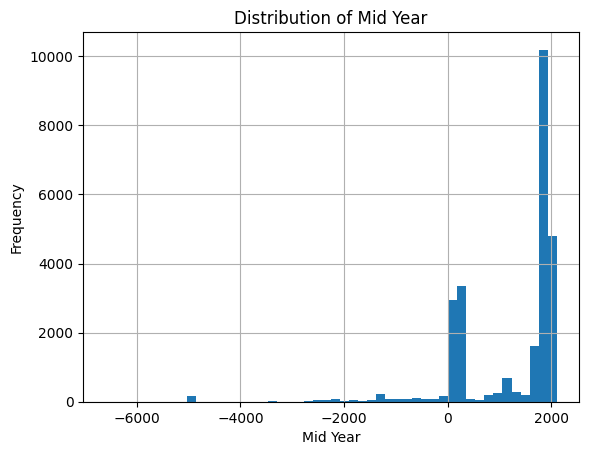

In [93]:
year_df["mid_year"].hist(bins=50)
plt.xlabel("Mid Year")
plt.ylabel("Frequency")
plt.title("Distribution of Mid Year")
plt.show()

### Object name

In [106]:
full_df["object_name"].value_counts()[:15]

object_name
sherds             5068
photographs        4729
coins              4609
amulets            2485
Woodblock Print    1386
figures            1316
vessels            1165
bowls               807
Papercut            731
pages               647
Slide               633
jars                566
Seal                554
postcards           541
vases               518
Name: count, dtype: int64

### Material

In [104]:
full_df["material"].value_counts()

material
pottery                8844
paper                  5822
metal                  3739
photographic paper     3396
faience                2961
                       ... 
Shell (Ostrich Egg)       1
serpentinite              1
balsa                     1
maple                     1
fabric art                1
Name: count, Length: 414, dtype: int64